##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using text and neural network features

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/universal-sentence-encoder/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>


Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn about some more advanced capabilities of **TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.

## Setup

Import the necessary libraries.

In [12]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

The hidden code cell limits the output height in colab.

In [13]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [14]:
from google.cloud import storage
import io
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/ralf/.config/gcloud/application_default_credentials.json"
os.environ['GOOGLE_CLOUD_PROJECT'] = "359515640875"
client = storage.Client()
bucket = client.get_bucket('06fff4a5ff3c1cb7a4089a63899047ff8dcd')
# Then do other things...
blob1 = bucket.get_blob('ROTVRSV')
blob2 = bucket.get_blob('DENV')
in_memory_file1 = io.BytesIO()
blob1.download_to_file(in_memory_file1)
in_memory_file1.seek(0)
in_memory_file2 = io.BytesIO()
blob2.download_to_file(in_memory_file2)
in_memory_file2.seek(0)

0

In [15]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

# Assuming your dataset is stored in a CSV file
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"

trds = pd.read_json(in_memory_file1,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()

In [16]:
def prepare_dataset1(example, label):
    return {"sentence" : tf.strings.split(example["preprocessedText"])}, label

def prepare_dataset2(s):
    m = json.loads(s)
    sp = tf.strings.split(m["preprocessedText"])
#    print(sp)
#    m["prep"] = tf.RaggedTensor.from_tensor(sp, ragged_rank=1)
#    m["prep"] = tf.constant(sp)
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
#for features, label in test_ds:
#    print("features:", features)
#    print("label:", label)
#    break
    
test_cases = list(map(prepare_dataset2, test_lines))

In [17]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=300, verbose=2, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

<IPython.core.display.Javascript object>

Use /tmp/tmpbpn_cc8s as temporary training directory


Reading training dataset...
Training tensor examples:
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}


2023-07-16 18:44:30.154343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_3}}]]


Training dataset read in 0:00:00.270971. Found 22996 examples.
Training model...


[INFO 23-07-16 18:44:30.4231 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-16 18:44:30.4232 CEST kernel.cc:774] Collect training examples
[INFO 23-07-16 18:44:30.4232 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-16 18:44:30.4233 CEST kernel.cc:393] Number of batches: 23
[INFO 23-07-16 18:44:30.4233 CEST kernel.cc:394] Number of examples: 22996
[INFO 23-07-16 18:44:30.4860 CEST data_spec_inference.cc:305] 35489 item(s) have been pruned (i.e. they are considered out of dictionary) for the column sentence (2000 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-07-16 18:44:30.5463 CEST

[INFO 23-07-16 18:51:35.6501 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.841973 logloss:0.386871
[INFO 23-07-16 18:51:46.8035 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.842451 logloss:0.38683
[INFO 23-07-16 18:51:58.1628 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.841799 logloss:0.386792
[INFO 23-07-16 18:52:10.1385 CEST random_forest.cc:802] Training of tree  229/300 (tree index:228) done accuracy:0.842668 logloss:0.386724
[INFO 23-07-16 18:52:22.0452 CEST random_forest.cc:802] Training of tree  235/300 (tree index:235) done accuracy:0.843364 logloss:0.386433
[INFO 23-07-16 18:52:33.9171 CEST random_forest.cc:802] Training of tree  241/300 (tree index:240) done accuracy:0.843929 logloss:0.386209
[INFO 23-07-16 18:52:46.0135 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.843625 logloss:0.386268
[INFO 23-07-16 18:52:57.7107

Model trained in 0:10:03.024267
Compiling model...


2023-07-16 18:54:33.522754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [22996]
	 [[{{node Placeholder/_0}}]]


Model compiled.


In [19]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

9/9 [==============================] - 2s 181ms/step - loss: 0.0000e+00 - accuracy: 0.9079
BinaryCrossentropyloss: 0.0
Accuracy: 0.9079387187957764


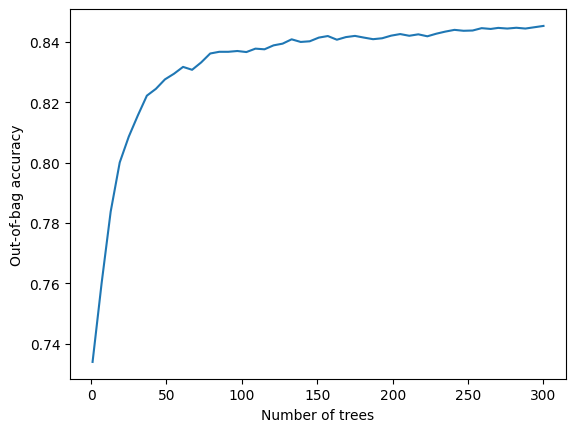

In [20]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [21]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

9/9 [==============================] - 2s 178ms/step
cut: 0.25, acc: 0.6406268003226178, prec: 0.4180082366154998, rec: 0.9955416852429781, f1: 0.588793671720501
cut: 0.3, acc: 0.7269270653301072, prec: 0.4860837168529476, rec: 0.9888542131074454, f1: 0.6517778430796356
cut: 0.35, acc: 0.7921419518377694, prec: 0.5556965237249429, rec: 0.9763709317877842, f1: 0.7082794307891332
cut: 0.39999999999999997, acc: 0.8420324922226063, prec: 0.627039627039627, rec: 0.9594293357111012, f1: 0.7584140969162995
cut: 0.44999999999999996, acc: 0.8789030994354188, prec: 0.7014874915483434, rec: 0.925100312082033, f1: 0.7979234762545664
cut: 0.49999999999999994, acc: 0.9079387026155087, prec: 0.7849250197316495, rec: 0.8867588051716451, f1: 0.8327402135231317
cut: 0.5499999999999999, acc: 0.923493490033414, prec: 0.863992623328723, rec: 0.8354881854658939, f1: 0.8495013599274704
cut: 0.5999999999999999, acc: 0.9120866459269501, prec: 0.9048140043763676, rec: 0.7374052608114133, f1: 0.8125767624662246


In [15]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for c in np.arange(0., .5, .05):
        s = 0
        t = 0
        for i in range(N):
            tru = test_cases[i]["label"] == '1'
            val = int((p[i]+0.005) * 100)
            pred = False
            if val > cut:
                pred = True
            elif val > 100*c:
                s = s+1
                if tru:
                    t = t+1
        print("c: {}, n = {}, tru: {}".format(c, s, t))

c: 0.0, n = 6525, tru: 378
c: 0.05, n = 6396, tru: 378
c: 0.1, n = 5885, tru: 377
c: 0.15000000000000002, n = 4983, tru: 376
c: 0.2, n = 4009, tru: 374
c: 0.25, n = 3139, tru: 368
c: 0.30000000000000004, n = 2379, tru: 351
c: 0.35000000000000003, n = 1765, tru: 323
c: 0.4, n = 1261, tru: 281
c: 0.45, n = 785, tru: 209
